**Задание 1. A/B–тестирование**

1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import norm
import math
import scipy.stats

pallet_name = "Pastel2"
my_pallet = sns.color_palette(pallet_name)
sns.set_palette(pallet_name, n_colors=7)

In [6]:
active_studs = pd.read_csv("Проект_2_active_studs.csv")
checks = pd.read_csv(
    "Проект_2_checks.csv",
    sep=";",
    names=["student_id", "revenue"],
    header=None,
    skiprows=1,
)
group_add = pd.read_csv(
    "Проект_2_group_add.csv",
    sep=",",
    names=["student_id", "group"],
    header=None,
    skiprows=1,
)
groups = pd.read_csv(
    "Проект_2_groups.csv",
    sep=";",
    names=["student_id", "group"],
    header=None,
    skiprows=1,
)

в файле **groups** находятся id студентов и принадлежность к группе. 
* Проверим на дубликаты айдишники
* Посмотрим на распределение студентов по группам

In [7]:
groups.shape

(74484, 2)

In [8]:
groups.nunique()

student_id    74484
group             2
dtype: int64

/var/folders/46/9vffld4939lbtd69_c_ftcx80000gn/T/ipykernel_83786/885273090.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


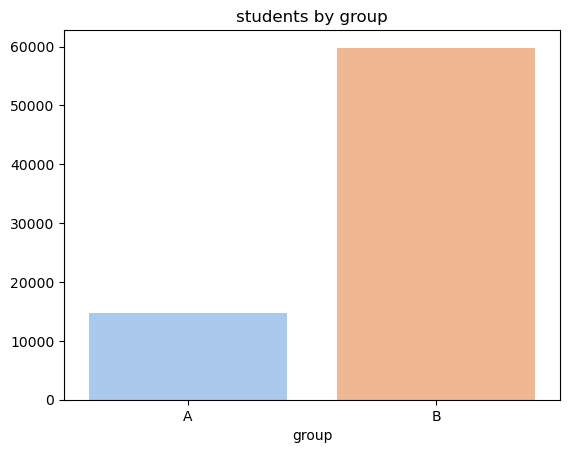

In [9]:
groups = groups.sort_values("group")
distr_by_group = groups.group.value_counts(sort=False)

sns.barplot(
    x=distr_by_group.index, y=distr_by_group.values, palette="pastel"
).set_title("students by group")
plt.show()

в тестовой группе в 4 раза больше студентов, распределение неравномерно.

**active_studs** - файл с студентами, которые проявляли активность во время эксперимента. 
* Проверим на дубликаты и убедимся, что всем присвоена группа.
* Добавим в файл group столбец с информацией, активен ли студент.

In [10]:
active_studs.shape

(8341, 1)

In [11]:
active_studs.nunique()

student_id    8341
dtype: int64

In [12]:
groups["active"] = groups.student_id.isin(active_studs.student_id)

In [13]:
groups.head()

,student_id,group,active
41335,1904613,A,False
14547,653313,A,False
31973,1439700,A,False
62807,4078576,A,False
31976,1439925,A,False


In [14]:
groups.dropna(subset=["group"], inplace=True)

В файле **checks** находится информация об оплатах в дни проведения эксперимента
Проверим на дубликаты



In [15]:
checks.shape

(541, 2)

In [16]:
checks.nunique()

student_id    541
revenue        39
dtype: int64

In [17]:
checks["purchase"] = True

In [18]:
full_data = groups.merge(checks, how="left", on="student_id")

In [19]:
# full_data.revenue.fillna(0, inplace=True) #заменяем NaNы на нули в колонке revenue

In [20]:
full_data.shape  # все на месте

(74484, 5)

In [21]:
checks.student_id.nunique()  # смотрим, сколько человек совершило покупку

541

посмотрим, были ли покупки у неактивных студентов

In [22]:
full_data.query("revenue != 0 & active == False").count()

student_id    66156
group         66156
active        66156
revenue         149
purchase        149
dtype: int64

149 студентов были не активны, но при этом совершили покупку. Предположим, что платформа работает по подписке и это автоматические списание. 
* Выберем **целевой** метрикой **CR** - конверсия активного пользователя в покупку.
* Посчитаем **ARPPU** - средний доход с платящего пользователя.
* Создадим массив с метриками.


In [23]:
# посмотрим распределение активных и совершивших оплату студентов
active_with_payment = (
    full_data.query("active == True & revenue > 0").group.value_counts().sort_values()
)

/var/folders/46/9vffld4939lbtd69_c_ftcx80000gn/T/ipykernel_83786/3786138933.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(active_with_payment.revenue, kde=True, bins=15, palette="pastel")


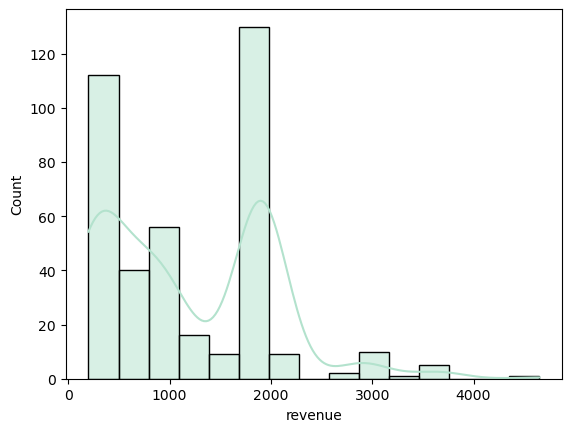

In [24]:
active_with_payment = full_data.query("active == True & revenue > 0")
# посмотрим на распределение покупок среди активных студентов
sns.histplot(active_with_payment.revenue, kde=True, bins=15, palette="pastel")
plt.show()

распределение неравномерное, много оплат в районе 2 тысяч. посмотрим на топ оплат 

In [25]:
active_with_payment.revenue.round(2).value_counts().head(5)

revenue
1900.0    127
290.0      70
199.0      32
840.0      24
990.0      22
Name: count, dtype: int64

Больше всего оплат на 1900. Предположу, что это самый популярный продукт платформы.
Посмотрим, как распределялись покупки по группам.

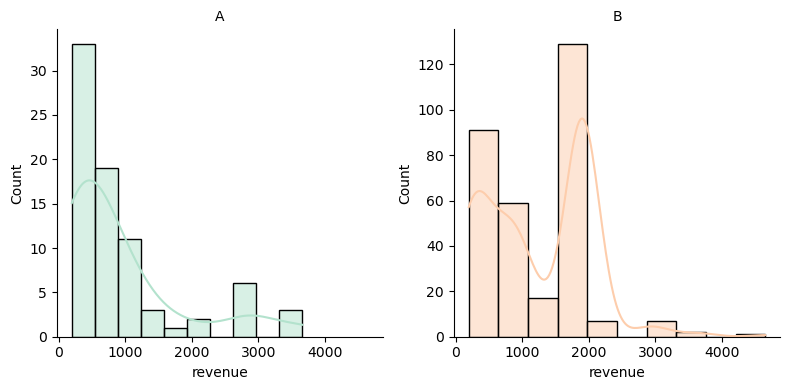

In [26]:
purchases_by_group = sns.FacetGrid(
    active_with_payment, col="group", sharey=False, height=4, hue="group"
)

purchases_by_group = purchases_by_group.map(sns.histplot, "revenue", kde=True, bins=10)
purchases_by_group.set_titles(col_template="{col_name}")
plt.show()

почти все покупки в 1900 пришлись на тестовую группу

Построим таблицу с основными метриками.

In [27]:
full_data["revenue_all"] = full_data.apply(lambda x: max(0, x.revenue), axis=1)
full_data["revenue_active"] = full_data.apply(
    lambda x: max(0, x.revenue) if x.active else np.nan, axis=1
)
full_data["purchase_active"] = full_data.apply(
    lambda x: x.revenue_active > 0 if x.active else np.nan, axis=1
)

In [28]:
rename = {
    "active": "CR_to_active",
    "purchase_active": "CR_active_to_purchase",
    "revenue_all": "ARPU",
    "revenue_active": "ARPAU",
    "revenue": "ARPPU",
}

In [29]:
metrics = (
    full_data.groupby("group", as_index=False)
    .agg(
        {
            "active": "mean",
            "purchase_active": "mean",
            "revenue_all": "mean",
            "revenue_active": "mean",
            "revenue": "mean",
        }
    )
    .rename(columns=rename)
)

In [30]:
metrics.style.format(
    {
        "CR_to_active": "{:.2%}",
        #'CR_to_purchase': '{:.2%}',
        "CR_active_to_purchase": "{:.2%}",
        "ARPU": "{:.2f}",
        "ARPAU": "{:.2f}",
        "ARPPU": "{:.2f}",
    }
)

,group,CR_to_active,CR_active_to_purchase,ARPU,ARPAU,ARPPU
0,A,10.46%,5.08%,6.28,47.44,860.71
1,B,11.36%,4.61%,8.01,57.86,1107.00


Проверим, является ли конверсия в покупку статистически значимой. Сформулируем гипотезы:

**H0** - нет взаимосвязи между группой и оплатой.
**H1** - оплата и группа взаимосвязаны.
**Применим тест хи квадрат**

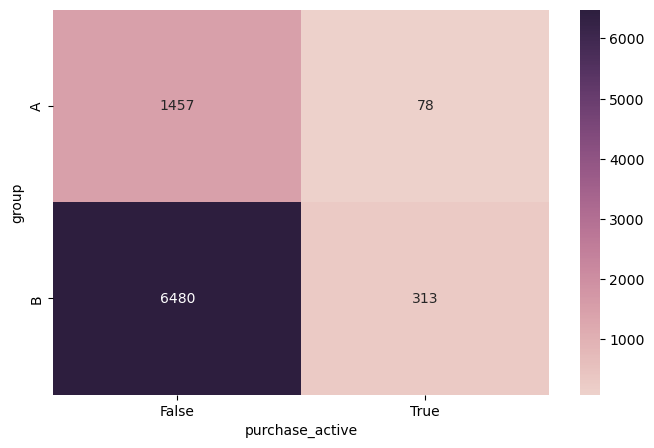

In [31]:
table = full_data.query("active").pivot_table(
    values="student_id", index="group", columns="purchase_active", aggfunc="count"
)

plt.figure(figsize=(8, 5))
sns.heatmap(table, annot=True, fmt="d", cmap=sns.cubehelix_palette(as_cmap=True))
plt.show()

In [32]:
chi2, p, dof, ex = scipy.stats.chi2_contingency(table, correction=False)
print(p, chi2)

0.4280822964525912 0.6280206142073419


**p_value > 0.05.** Не можем отклонить нулевую гипотезу. Вывод - CR активного пользователя в покупку статистически **не изменилось**

Проверим является ли изменение ARPPU (среднего дохода платящего пользователя) статистически значимым.
Сформулируем гипотезы:

* **H0** - различий между средними значениями нет.
* **H1** - средние значения не равны

Проверим, удовлетворяют ли данные критериями для проведения t-теста
критерии:
1. гомогенность дисперсии
2. нормальное распределение среднего
3. отсутствие значительных выбросов

In [33]:
a_revenue = full_data.query("group == 'A' & ~revenue.isna()").revenue
b_revenue = full_data.query("group == 'B' & ~revenue.isna()").revenue

In [34]:
scipy.stats.levene(a_revenue, b_revenue)

LeveneResult(statistic=4.099799827819432, pvalue=0.04338169367714307)

p_value < 0.05, что позволяет нам отклонить нулевую гипотезу.
Проверим выбросы

/var/folders/46/9vffld4939lbtd69_c_ftcx80000gn/T/ipykernel_83786/4223671626.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="group", y="revenue", data=full_data, palette="pastel")


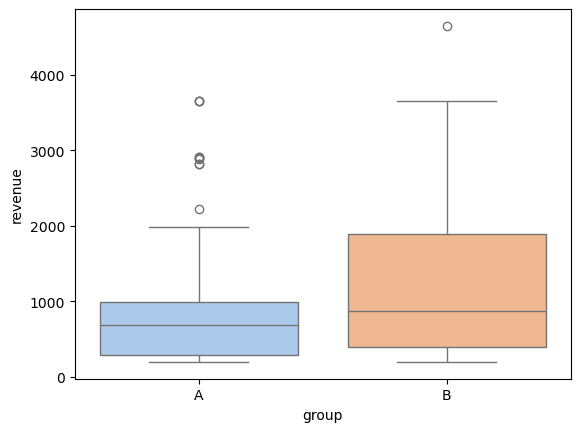

In [35]:
sns.boxplot(x="group", y="revenue", data=full_data, palette="pastel")
plt.show()

наблюдаются выбросы в обеих группах. 
Проверим распределение на нормальность c помощью теста **Шапиро-Уилка**

In [36]:
scipy.stats.shapiro(a_revenue)

ShapiroResult(statistic=0.7196123600006104, pvalue=5.321687643507211e-13)

In [37]:
scipy.stats.shapiro(b_revenue)

ShapiroResult(statistic=0.8673096895217896, pvalue=9.537710927272242e-19)

в обоих случаях **p_value < 0.05**, что говорит нам о ненормальности распределения
ни одно из условии t-теста не выполнено.
воспользуемся **bootstrap**

In [38]:
boot_len = full_data.groupby("group").agg({"purchase": "sum"}).purchase.max()
a = full_data.query("group == 'A' & ~revenue.isna()").revenue
b = full_data.query("group == 'B' & ~revenue.isna()").revenue

boot_data = []
for _ in range(10000):
    mean_a = np.mean(a.sample(boot_len, replace=True).values)
    mean_b = np.mean(b.sample(boot_len, replace=True).values)
    boot_data.append(mean_b - mean_a)

pd_boot_data = pd.DataFrame(boot_data)
quants = pd_boot_data.quantile([0.05 / 2, 1 - 0.05 / 2])

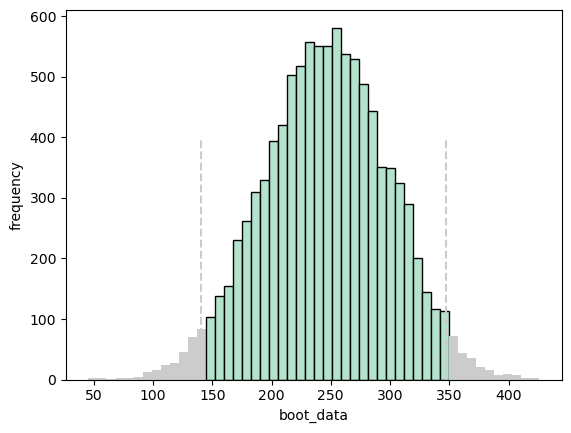

In [39]:
_, _, bars = plt.hist(pd_boot_data[0], bins=50)
for bar in bars:
    if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
        bar.set_facecolor(my_pallet[-1])
    else:
        bar.set_facecolor(my_pallet[0])
        bar.set_edgecolor("black")

plt.vlines(quants, ymin=0, ymax=400, linestyle="--", color=my_pallet[-1])
plt.xlabel("boot_data")
plt.ylabel("frequency")
plt.show()

In [40]:
p_1 = scipy.stats.norm.cdf(0, np.mean(boot_data), np.std(boot_data))
p_2 = scipy.stats.norm.cdf(0, -np.mean(boot_data), np.std(boot_data))
p_value = min(p_1, p_2) * 2
p_value

3.4197026100239503e-06

**p-value < 0.05**
У нас достаточно оснований отклонить нулевую гипотезу т.к. ARPPU в тестовой и контрольной группе статистически значимо отличаются.

**Вывод**
**Целевой метрикой проведения A/B тестирования был выбран CR активного пользователя в покупку. CR статистически значимо не изменился.
ARPPU статистически значимо увеличился. Возможно в дни эксперимента проводились какие-то акции.
В любом случае можно оставить новую механику оплаты.**


Реализую функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.

In [41]:
def get_metrics(
    active_students_path: str,
    checks_path: str,
    groups_path: str,
    groups_add_path: str,
) -> pd.DataFrame:
    active_studs = pd.read_csv(active_students_path)
    checks = pd.read_csv(
        checks_path,
        sep=";",
        names=["student_id", "revenue"],
        header=None,
        skiprows=1,
    )

    groups = pd.read_csv(
        groups_path,
        sep=";",
        names=["student_id", "group"],
        header=None,
        skiprows=1,
    )
    group_add = pd.read_csv(
        groups_add_path,
        sep=",",
        names=["student_id", "group"],
        header=None,
        skiprows=1,
    )

    groups = pd.concat([groups, group_add])

    groups = groups.sort_values("group")

    groups["active"] = groups.student_id.isin(active_studs.student_id)

    groups.dropna(subset=["group"], inplace=True)

    checks["purchase"] = True

    full_data = groups.merge(checks, how="left", on="student_id")

    full_data["revenue_all"] = full_data.apply(lambda x: max(0, x.revenue), axis=1)
    full_data["revenue_active"] = full_data.apply(
        lambda x: max(0, x.revenue) if x.active else np.nan, axis=1
    )
    full_data["purchase_active"] = full_data.apply(
        lambda x: x.revenue_active > 0 if x.active else np.nan, axis=1
    )

    rename = {
        "active": "CR_to_active",
        "purchase_active": "CR_active_to_purchase",
        "revenue_all": "ARPU",
        "revenue_active": "ARPAU",
        "revenue": "ARPPU",
    }

    metrics = (
        full_data.groupby("group", as_index=False)
        .agg(
            {
                "active": "mean",
                "purchase_active": "mean",
                "revenue_all": "mean",
                "revenue_active": "mean",
                "revenue": "mean",
            }
        )
        .rename(columns=rename)
    )

    return metrics


metrics = get_metrics(
    active_students_path="Проект_2_active_studs.csv",
    checks_path="Проект_2_checks.csv",
    groups_path="Проект_2_groups.csv",
    groups_add_path="Проект_2_group_add.csv",
)

metrics.style.format(
    {
        "CR_to_active": "{:.2%}",
        "CR_active_to_purchase": "{:.2%}",
        "ARPU": "{:.2f}",
        "ARPAU": "{:.2f}",
        "ARPPU": "{:.2f}",
    }
)

,group,CR_to_active,CR_active_to_purchase,ARPU,ARPAU,ARPPU
0,A,10.47%,5.07%,6.27,47.35,860.71
1,B,11.36%,4.62%,8.04,58.06,1108.82


Также написала функцию, которая будет строить графики по получаемым метрикам.

In [42]:
def get_graphics1(metrics):
    # установим размер
    plt.figure(figsize=(20, 6))
    # ARPPU
    plt.subplot(1, 3, 1)
    bar = sns.barplot(x="group", y="ARPPU", data=metrics)
    # назначаем названия
    bar.axes.set_title("ARPPU", fontsize=16)
    bar.set_xlabel("Group", fontsize=12)
    bar.set_ylabel("ARPPU", fontsize=12)
    bar.bar_label(bar.containers[0])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # ARPU
    plt.subplot(1, 3, 2)
    bar = sns.barplot(x="group", y="ARPU", data=metrics)
    bar.axes.set_title("ARPU", fontsize=16)
    bar.set_xlabel("Group", fontsize=12)
    bar.set_ylabel("ARPU", fontsize=12)
    bar.bar_label(bar.containers[0])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # ARPAU
    plt.subplot(1, 3, 3)
    bar = sns.barplot(x="group", y="ARPAU", data=metrics)
    bar.axes.set_title("ARPAU", fontsize=16)
    bar.set_xlabel("Group", fontsize=12)
    bar.set_ylabel("ARPAU", fontsize=12)
    bar.bar_label(bar.containers[0])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

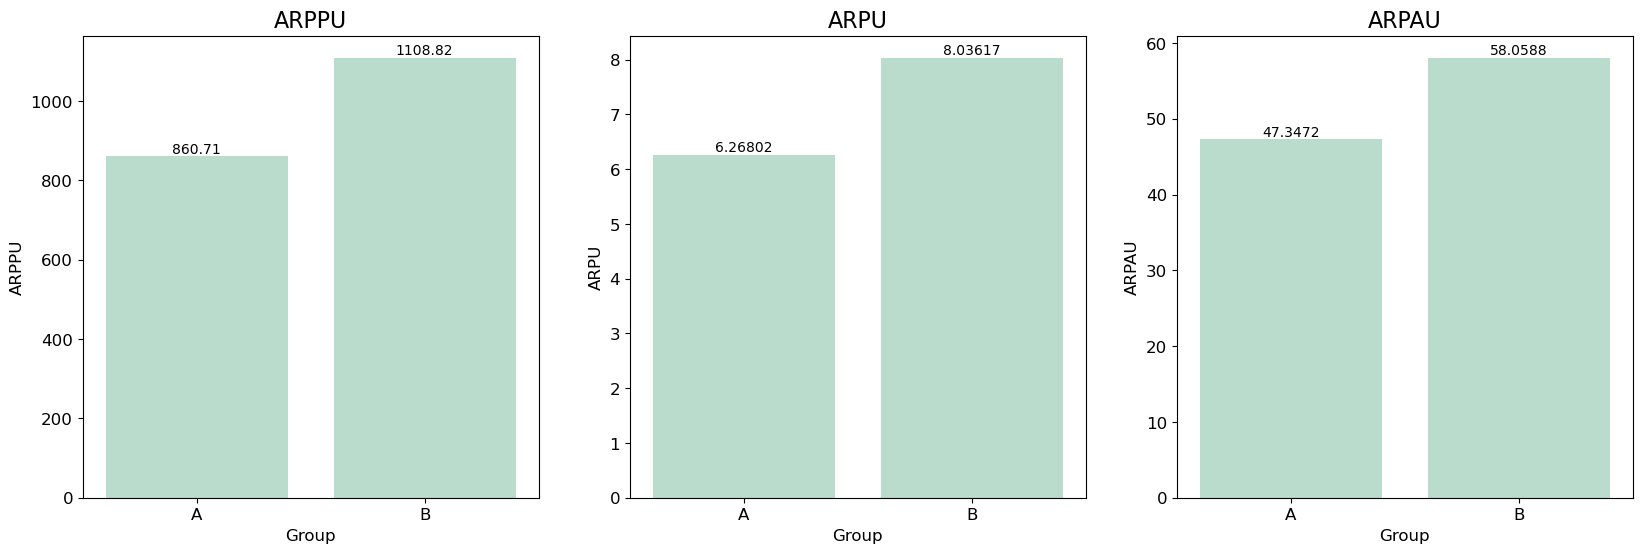

In [43]:
get_graphics1(metrics)

In [44]:
def get_graphics2(metrics):
    # установим размер
    plt.figure(figsize=(15, 6))
    # CR_to_active
    plt.subplot(1, 3, 1)
    bar = sns.barplot(x="group", y="ARPPU", data=metrics)
    # назначаем названия
    bar.axes.set_title("CR_to_active", fontsize=16)
    bar.set_xlabel("Group", fontsize=12)
    bar.set_ylabel("CR_to_active", fontsize=12)
    bar.bar_label(bar.containers[0])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    # CR_active_to_purchase
    plt.subplot(1, 3, 2)
    bar = sns.barplot(x="group", y="CR_active_to_purchase", data=metrics)
    bar.axes.set_title("CR_active_to_purchase", fontsize=16)
    bar.set_xlabel("Group", fontsize=12)
    bar.set_ylabel("CR_active_to_purchase", fontsize=12)
    bar.bar_label(bar.containers[0])
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

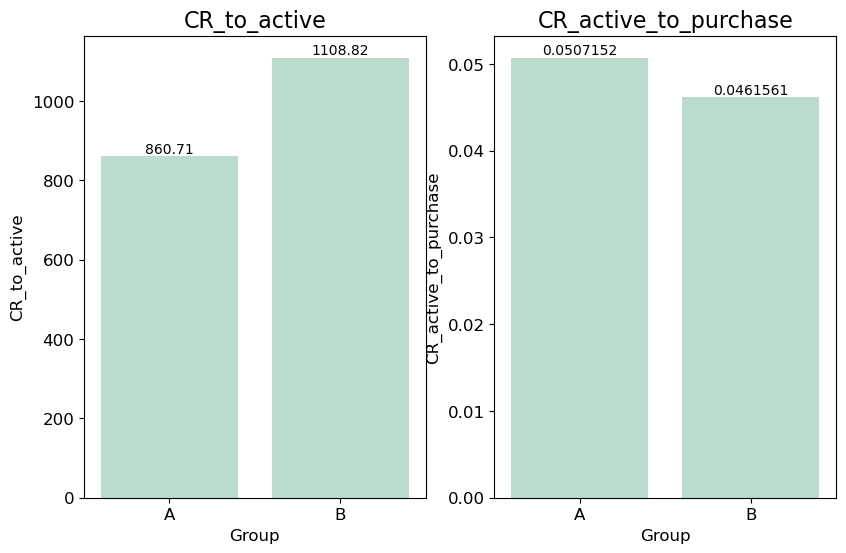

In [45]:
get_graphics2(metrics)